In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Explore columns and data in each table
md = sqlalchemy.MetaData()
MeasurementTable = sqlalchemy.Table('Measurement', md, autoload=True, autoload_with=engine)
MeasurementColumns = MeasurementTable.c
for c in MeasurementColumns:
    print(c.name, c.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
StationTable = sqlalchemy.Table('Station', md, autoload=True, autoload_with=engine)
StationColumns = StationTable.c
for c in StationColumns:
        print(c.name, c.type)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
#Get max date
MaxDate = engine.execute("SELECT MAX(date) FROM Measurement").fetchall()

print(MaxDate)

[('2017-08-23',)]


In [16]:
#Get min date - (just curious)
MinDate = engine.execute("SELECT MIN(date) FROM Measurement").fetchall()
print(MinDate)

[('2010-01-01',)]


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

In [18]:
#Calc one year prior to max date
YearPriorMaxDate = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(YearPriorMaxDate)

2016-08-23


In [19]:

# Perform a query to retrieve the data and precipitation scores
#results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>='2016-08-23').\
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=YearPriorMaxDate).\
    filter(Measurement.date <='2017-08-23').\
    order_by(Measurement.date.desc()).all()



In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(results)
prcpmean_df = pd.DataFrame(prcp_df.groupby(['date']).agg({'prcp':'mean'}))
prcpmean_df.head()

prcp
date                
2016-08-23  0.451667
2016-08-24  1.555000
2016-08-25  0.077143
2016-08-26  0.016667
2016-08-27  0.064000

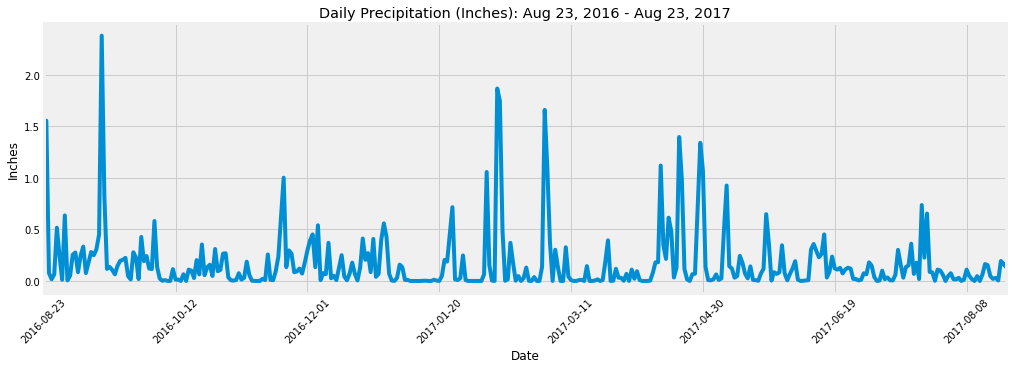

In [21]:
prcpmean_df.plot(figsize =(14, 5), rot = 45, legend=False)
plt.tight_layout()
plt.title("Daily Precipitation (Inches): Aug 23, 2016 - Aug 23, 2017")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig("dailyprecipitation.png")
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [23]:
# Design a query to show how many stations are available in this dataset?
StationCount = engine.execute("SELECT COUNT(station) FROM Station").fetchall()
print(StationCount)

[(9,)]


In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

StationCount = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

#print(StationCount)

StationCount_df = pd.DataFrame.from_records(StationCount, columns=['Station', 'Observations'])
StationCount_df


Station  Observations
0  USC00519281          2772
1  USC00519397          2724
2  USC00513117          2709
3  USC00519523          2669
4  USC00516128          2612
5  USC00514830          2202
6  USC00511918          1979
7  USC00517948          1372
8  USC00518838           511

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Which station has the highest number of observations?
#MostActiveStation = session.query(Station.name).filter(Station.station == StationCount_df['Station'][0]).all()
MostActiveStationID = str(StationCount_df['Station'][0])


TempResults = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter_by(station = MostActiveStationID).all()
print(TempResults)

[(54.0, 85.0, 71.66378066378067)]


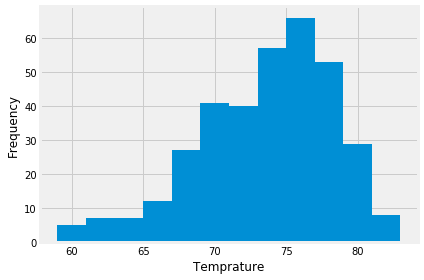

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highestObs_pd = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.date>='2016-08-23', Measurement.station == MostActiveStationID).all())
highestObs_pd.plot.hist(bins=12,  legend = False)
plt.xlabel("Temprature")
plt.tight_layout()
plt.savefig("histogram.png")

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#start_date = '2017-01-15'
start_date = input("What is the first day of your trip (YYYY-MM-DD)")
start_date = pd.to_datetime(start_date)- dt.timedelta(days = 365)
start_date = start_date.strftime('%Y-%m-%d')

#end_date = '2017-01-31'
end_date = input("What is the last day of your trip (YYYY-MM-DD)")
end_date = pd.to_datetime(end_date)- dt.timedelta(days = 365)
end_date = end_date.strftime('%Y-%m-%d')

print(calc_temps(start_date, end_date))

What is the first day of your trip (YYYY-MM-DD)2017-01-15
What is the last day of your trip (YYYY-MM-DD)2017-01-30
[(61.0, 69.51578947368421, 78.0)]


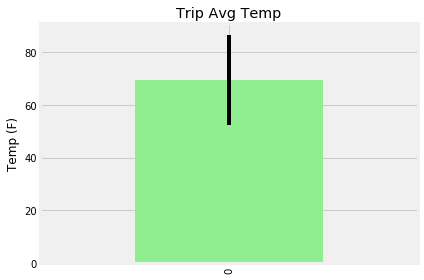

In [29]:

# Plot the results from your previous query as a bar chart. 
columns = ['tmin', 'tavg', 'tmax']
row = list(calc_temps(start_date, end_date)[0])
df = pd.DataFrame({x[0]: x[1] for x in zip(columns, row)}, index=[0])

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error_bar = df.tmax - df.tmin
df.plot(y='tavg', kind='bar', color='lightgreen', yerr=y_error_bar, grid=True, title='Trip Avg Temp', legend=False)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.savefig('./Images/avg_temp_errorbar.png')
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

qry = f"SELECT s.station, s.name, s.latitude, s.longitude, s.elevation, SUM(m.prcp) AS Rainfall FROM station s INNER JOIN measurement m ON m.station = s.station AND m.date BETWEEN '{start_date}' AND '{end_date}' GROUP BY s.station, s.name, s.latitude, s.longitude, s.elevation ORDER BY Rainfall DESC"
engine.execute(qry).fetchall()

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.35),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.64),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.64),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.63),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.47000000000000003),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22000000000000003),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


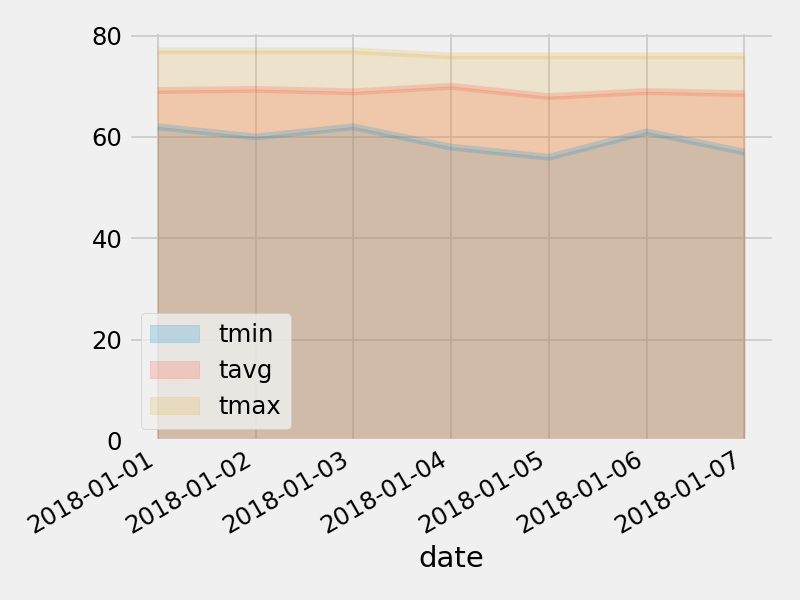

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
